In [28]:
!pip install -q git+https://github.com/MostafaShams5/NeuroMend.git

!pip install -q --upgrade torch torchvision torchaudio
!pip install -q diffusers transformers==4.41.2 accelerate bitsandbytes
!pip install -q umap-learn hdbscan matplotlib seaborn opencv-python
!pip install -q ultralytics qwen-vl-utils kagglehub

# 3. Clean start
import shutil
import os
for path in ["/kaggle/working/neuromend_output", "/kaggle/working/experiment_data", "/kaggle/working/raw_data"]:
    if os.path.exists(path): shutil.rmtree(path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.4.8 requires torch<2.10,>=1.8.0, but you have torch 2.10.0 which is incompatible.
fastai 2.8.4 requires fastcore<1.9,>=1.8.0, but you have fastcore 1.11.3 which is incompatible.
fastai 2.8.4 requires torch<2.9,>=1.10, but you have torch 2.10.0 which is incompatible.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.10.0 requires torch==2.10.0, but you have torch 2.9.1 which is incompatible.
fastai 2.8.4 requires fastcore<1.9,>=1.8.0, but you have fastcore 1.11.3 which is incompatible.
fastai 2.8.4 requires torch<2.9,>=1.10, but you have torch 2.9.1 which is incompatible.
[0 Environment Ready.


In [29]:
import torch
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import os
from transformers import AutoProcessor, AutoModelForCausalLM

class NeuroMendEngine:
    def __init__(self, device="cuda"):
        self.device = device
        print(f"[*] Loading Florence-2 (Robust Mode for Labeling & Reasoning)...")
        self.model = AutoModelForCausalLM.from_pretrained(
            "microsoft/Florence-2-large", 
            trust_remote_code=True,
            attn_implementation="eager", 
            torch_dtype=torch.float16
        ).to(self.device).eval()
        self.processor = AutoProcessor.from_pretrained("microsoft/Florence-2-large", trust_remote_code=True)

    def label_dataset(self, image_paths, target_class, output_dir):
        """Generates YOLO labels"""
        os.makedirs(output_dir, exist_ok=True)
        task_prompt = "<CAPTION_TO_PHRASE_GROUNDING>"
        text_input = f"{task_prompt} {target_class}"
        
        print(f"[*] Labeling {len(image_paths)} images...")
        for img_path in tqdm(image_paths):
            try:
                self._process_single_label(img_path, text_input, task_prompt, output_dir)
            except: pass

    def _process_single_label(self, img_path, text_input, task_prompt, output_dir):
        image = Image.open(img_path).convert("RGB")
        inputs = self.processor(text=text_input, images=image, return_tensors="pt").to(self.device, torch.float16)
        with torch.no_grad():
            generated_ids = self.model.generate(
                input_ids=inputs["input_ids"], pixel_values=inputs["pixel_values"],
                max_new_tokens=1024, num_beams=1, do_sample=False, use_cache=False
            )
        generated_text = self.processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        prediction = self.processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
        
        bboxes = prediction[task_prompt]['bboxes']
        if not bboxes: return

        yolo_lines = []
        for box in bboxes:
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            xc, yc = x1 + w/2, y1 + h/2
            yolo_lines.append(f"0 {xc/image.width:.6f} {yc/image.height:.6f} {w/image.width:.6f} {h/image.height:.6f}")
        
        with open(os.path.join(output_dir, os.path.basename(img_path).replace(".jpg", ".txt")), "w") as f:
            f.write("\n".join(yolo_lines))

    def diagnose(self, image_path):
        """Uses Detailed Captioning to find issues (Dark/Blur)"""
        task_prompt = "<DETAILED_CAPTION>"
        image = Image.open(image_path).convert("RGB")
        inputs = self.processor(text=task_prompt, images=image, return_tensors="pt").to(self.device, torch.float16)
        
        with torch.no_grad():
            generated_ids = self.model.generate(
                input_ids=inputs["input_ids"], pixel_values=inputs["pixel_values"],
                max_new_tokens=100, num_beams=1, do_sample=False, use_cache=False
            )
        caption = self.processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        
        diagnosis = []
        caption_lower = caption.lower()
        if "dark" in caption_lower or "night" in caption_lower or "shadow" in caption_lower: diagnosis.append("low light")
        if "blur" in caption_lower or "grainy" in caption_lower: diagnosis.append("motion blur")
        if "rain" in caption_lower or "wet" in caption_lower: diagnosis.append("rainy")
        
        return ", ".join(diagnosis) if diagnosis else "low visibility"

def flush():
    import gc
    gc.collect()
    torch.cuda.empty_cache()

In [30]:
import kagglehub
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
import shutil
import os

RAW_DIR = "/kaggle/working/raw_data"
EXP_DIR = "/kaggle/working/experiment_data"
if os.path.exists(RAW_DIR): shutil.rmtree(RAW_DIR)
if os.path.exists(EXP_DIR): shutil.rmtree(EXP_DIR)
os.makedirs(RAW_DIR, exist_ok=True)

ds_path = kagglehub.dataset_download("sachinpatel21/pothole-image-dataset")
src_images = [y for x in os.walk(ds_path) for y in glob(os.path.join(x[0], '*.jpg'))][:700]

all_images = []
for i, src in enumerate(src_images):
    try:
        img = cv2.imread(src)
        if img is not None:
            dst = f"{RAW_DIR}/pothole_{i}.jpg"
            cv2.imwrite(dst, img)
            all_images.append(dst)
    except: pass

train_imgs, test_imgs = train_test_split(all_images, test_size=0.3, random_state=42)

train_dir = f"{EXP_DIR}/train_clean"
os.makedirs(train_dir, exist_ok=True)
for p in train_imgs: shutil.copy(p, f"{train_dir}/{os.path.basename(p)}")

test_dir = f"{EXP_DIR}/test_hard"
os.makedirs(test_dir, exist_ok=True)

print("[*] Applying corruptions to Test Set...")
for p in test_imgs:
    img = cv2.imread(p)
    
    size = 20 
    kernel = np.zeros((size, size))
    kernel[int((size-1)/2), :] = np.ones(size) / size
    blur = cv2.filter2D(img, -1, kernel)
    
    noise = np.random.normal(0, 25, blur.shape).astype(np.uint8)
    noisy = cv2.add(blur, noise)
    
    final = (noisy * 0.6).astype(np.uint8)
    
    cv2.imwrite(f"{test_dir}/{os.path.basename(p)}", final)


--- 1. Downloading Data ---
--- 2. Creating BRUTAL Domain Shift ---
[*] Applying corruptions to Test Set...
 Data Ready. Baseline will struggle.


In [31]:
print("--- 3. Labeling Data ---")
labeler = SafeAutoLabeler()
# Label Train
labeler.label_dataset([f"{train_dir}/{x}" for x in os.listdir(train_dir)], "pothole", train_dir)
# Label Test (Ground Truth)
labeler.label_dataset([f"{test_dir}/{x}" for x in os.listdir(test_dir)], "pothole", test_dir)
del labeler
flush()

--- 3. Labeling Data ---
[*] Loading Florence-2 (Labeler)...
[*] Auto-labeling 210 images...


100%|██████████| 210/210 [01:20<00:00,  2.62it/s]


[*] Auto-labeling 90 images...


100%|██████████| 90/90 [00:31<00:00,  2.84it/s]


In [32]:
from ultralytics import YOLO

CFG_DIR = "/kaggle/working/yolo_cfg"
for s in ['train', 'val']:
    os.makedirs(f"{CFG_DIR}/{s}/images", exist_ok=True)
    os.makedirs(f"{CFG_DIR}/{s}/labels", exist_ok=True)

def copy_data(src, split):
    for f in os.listdir(src):
        if f.endswith(".jpg"): shutil.copy(f"{src}/{f}", f"{CFG_DIR}/{split}/images/{f}")
        if f.endswith(".txt"): shutil.copy(f"{src}/{f}", f"{CFG_DIR}/{split}/labels/{f}")

copy_data(train_dir, "train")
copy_data(test_dir, "val")

with open(f"{CFG_DIR}/data.yaml", "w") as f:
    f.write(f"path: {CFG_DIR}\ntrain: train/images\nval: val/images\nnc: 1\nnames: ['pothole']")

print("\n Training Baseline (Clean -> Hard)...")
model_a = YOLO("yolov8n.pt") 
res_a = model_a.train(data=f"{CFG_DIR}/data.yaml", epochs=8, imgsz=512, verbose=False, project="/kaggle/working/runs", name="base")
map_a = res_a.box.map50
print(f" Baseline mAP: {map_a:.4f}")


 Training Baseline (Clean -> Hard)...
Ultralytics 8.4.8 🚀 Python-3.12.12 torch-2.9.1+cu128 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_cfg/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=8, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=base2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, ove

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1324: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1326: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

train: Scanning /kaggle/working/yolo_cfg/train/labels... 477 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 477/477 1.2Kit/s 0.4s<0.2s
train: New cache created: /kaggle/working/yolo_cfg/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


val: Fast image access  (ping: 0.0±0.0 ms, read: 428.3±117.9 MB/s, size: 257.1 KB)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


val: Scanning /kaggle/working/yolo_cfg/val/labels... 229 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 229/229 1.4Kit/s 0.2s<0.2s
val: New cache created: /kaggle/working/yolo_cfg/val/labels.cache


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Plotting labels to /kaggle/working/runs/base2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to /kaggle/working/runs/base2
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        1/8      1.38G     0.9947      2.745      1.277        111        512: 0% ──────────── 0/30  0.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        1/8      1.38G     0.7713      1.876      1.182         67        512: 100% ━━━━━━━━━━━━ 30/30 5.7it/s 5.3s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 5.5it/s 1.5s0.2s
                   all        229        346      0.532      0.553      0.482      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        2/8      1.71G     0.8601      1.502      1.236         85        512: 0% ──────────── 0/30  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        2/8      1.71G     0.7764      1.326      1.169         67        512: 100% ━━━━━━━━━━━━ 30/30 7.7it/s 3.9s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 6.0it/s 1.3s0.2s
                   all        229        346      0.206      0.468       0.17     0.0509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        3/8      1.71G     0.7416      1.286      1.184         81        512: 3% ──────────── 1/30 2.6it/s 0.2s<11.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        3/8      1.71G     0.7628      1.223      1.171         65        512: 100% ━━━━━━━━━━━━ 30/30 8.4it/s 3.6s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 6.5it/s 1.2s0.2s
                   all        229        346      0.791      0.567      0.669      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        4/8      1.71G     0.7173      1.202      1.119         86        512: 0% ──────────── 0/30  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        4/8      1.71G     0.7248      1.151       1.15         68        512: 100% ━━━━━━━━━━━━ 30/30 8.4it/s 3.6s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 7.4it/s 1.1s0.2s
                   all        229        346      0.747      0.656      0.704      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        5/8      1.71G     0.7854      1.127      1.141         97        512: 3% ──────────── 1/30 2.7it/s 0.2s<10.8s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        5/8      1.71G      0.716      1.111      1.133         75        512: 100% ━━━━━━━━━━━━ 30/30 8.4it/s 3.6s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 5.7it/s 1.4s0.2s
                   all        229        346      0.903      0.673       0.76       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        6/8      1.72G     0.7262      1.132      1.225         77        512: 0% ──────────── 0/30  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        6/8      1.72G     0.6638      1.047      1.109         63        512: 100% ━━━━━━━━━━━━ 30/30 8.2it/s 3.6s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 5.9it/s 1.4s0.2s
                   all        229        346      0.741      0.679      0.684      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        7/8      1.72G     0.6774      1.036      1.184         88        512: 0% ──────────── 0/30  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        7/8      1.73G     0.6315     0.9937      1.102         67        512: 100% ━━━━━━━━━━━━ 30/30 8.2it/s 3.7s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 5.8it/s 1.4s0.2s
                   all        229        346      0.894      0.679      0.768      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        8/8      1.75G     0.5839     0.9618       1.07         62        512: 100% ━━━━━━━━━━━━ 30/30 8.4it/s 3.6s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 6.5it/s 1.2s0.2s
                   all        229        346      0.714      0.699      0.693      0.538

8 epochs completed in 0.012 hours.
Optimizer stripped from /kaggle/working/runs/base2/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/runs/base2/weights/best.pt, 6.2MB

Validating /kaggle/working/runs/base2/weights/best.pt...
Ultralytics 8.4.8  Python-3.12.12 torch-2.9.1+cu128 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 4.1it/s 2.0s0.2s
                   all        229        346      0.903      0.673       0.76       0.64
Speed: 0.1ms preprocess, 1.1ms inference, 

In [33]:
from neuro_mend import Generator

engine = NeuroMendEngine()

sample_fail = glob(f"{test_dir}/*.jpg")[0]
diagnosis = engine.diagnose(sample_fail)
print(f" Detected Failure Mode: '{diagnosis}'")

print("\n--- Neuro-Mend: Synthesis ---")
generator = Generator()
synth_out = "/kaggle/working/neuromend_fix"
# We inject the diagnosis into the prompt
prompt = f"pothole on road, {diagnosis}, motion blur, night, low quality, dashboard camera"

# Generate 60 Synthetic Images
clean_sources = glob(f"{train_dir}/*.jpg")
generator.synthesize(clean_sources, prompt, synth_out, count=60)
del generator
flush()

print("\n--- Neuro-Mend: Auto-Labeling ---")
engine.label_dataset(glob(f"{synth_out}/*.jpg"), "pothole", synth_out)
del engine
flush()

[*] Loading Florence-2 (Robust Mode for Labeling & Reasoning)...

--- Neuro-Mend: Diagnosis ---
 Detected Failure Mode: 'motion blur'

--- Neuro-Mend: Synthesis ---
[*] Initializing Generator with SDXL-Turbo on cuda...


model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


[*] Generating 60 images with prompt: 'high quality photo, realistic, pothole on road, motion blur, motion blur, night, low quality, dashboard camera'


100%|██████████| 60/60 [00:58<00:00,  1.03it/s]



--- Neuro-Mend: Auto-Labeling ---
[*] Labeling 60 images...


100%|██████████| 60/60 [00:21<00:00,  2.75it/s]


In [34]:
print("\n Training Patched Model (Clean + Synthetic Hard)...")

# Inject Synthetic Data
for f in os.listdir(synth_out):
    if f.endswith(".jpg"): shutil.copy(f"{synth_out}/{f}", f"{CFG_DIR}/train/images/syn_{f}")
    if f.endswith(".txt"): shutil.copy(f"{synth_out}/{f}", f"{CFG_DIR}/train/labels/syn_{f}")

model_b = YOLO("yolov8n.pt")
res_b = model_b.train(data=f"{CFG_DIR}/data.yaml", epochs=8, imgsz=512, verbose=False, project="/kaggle/working/runs", name="patch")
map_b = res_b.box.map50
print(f" Patched mAP: {map_b:.4f}")


 Training Patched Model (Clean + Synthetic Hard)...
Ultralytics 8.4.8  Python-3.12.12 torch-2.9.1+cu128 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_cfg/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=8, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=patch, nbs=64, nms=False, opset=None, optimize=False, optimi

/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1324: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
/usr/local/lib/python3.12/dist-packages/ultralytics/nn/modules/block.py:1326: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic 

train: Scanning /kaggle/working/yolo_cfg/train/labels... 537 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 537/537 1.5Kit/s 0.4s<0.1s
train: New cache created: /kaggle/working/yolo_cfg/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1081.8±1165.8 MB/s, size: 523.0 KB)
val: Scanning /kaggle/working/yolo_cfg/val/labels.cache... 229 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 229/229 7.7Mit/s 0.0s


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Plotting labels to /kaggle/working/runs/patch/labels.jpg... 


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to /kaggle/working/runs/patch
Starting training for 8 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        1/8      1.37G      0.961       2.72      1.227         97        512: 0% ──────────── 0/34  0.3s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        1/8      1.37G     0.7632      1.797      1.171         45        512: 100% ━━━━━━━━━━━━ 34/34 5.7it/s 6.0s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 7.6it/s 1.1s0.2s
                   all        229        346       0.55      0.535      0.451      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        2/8       1.7G     0.7537      1.379       1.22         80        512: 0% ──────────── 0/34  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        2/8       1.7G      0.767      1.306      1.192         38        512: 100% ━━━━━━━━━━━━ 34/34 7.6it/s 4.5s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 6.3it/s 1.3s0.2s
                   all        229        346      0.712      0.555      0.632      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        3/8       1.7G     0.7443      1.279      1.125         95        512: 0% ──────────── 0/34  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        3/8       1.7G     0.7681      1.246      1.183         44        512: 100% ━━━━━━━━━━━━ 34/34 8.3it/s 4.1s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 6.0it/s 1.3s0.2s
                   all        229        346      0.807      0.592      0.711      0.565

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        4/8       1.7G     0.7491      1.234      1.202         89        512: 3% ──────────── 1/34 2.5it/s 0.2s<13.4s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        4/8       1.7G     0.7431      1.181      1.175         42        512: 100% ━━━━━━━━━━━━ 34/34 8.3it/s 4.1s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 6.2it/s 1.3s0.2s
                   all        229        346      0.686      0.639      0.691      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        5/8       1.7G     0.6759      1.115      1.146         84        512: 3% ──────────── 1/34 2.7it/s 0.2s<12.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        5/8       1.7G     0.6999      1.118      1.143         54        512: 100% ━━━━━━━━━━━━ 34/34 8.6it/s 3.9s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 6.4it/s 1.3s0.2s
                   all        229        346      0.641      0.654      0.613      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        6/8       1.7G     0.6023      1.026      1.139         79        512: 3% ──────────── 1/34 2.4it/s 0.2s<13.8s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        6/8       1.7G     0.6449      1.065      1.124         28        512: 100% ━━━━━━━━━━━━ 34/34 8.4it/s 4.1s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 6.4it/s 1.2s0.2s
                   all        229        346      0.772      0.637      0.696      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        7/8       1.7G     0.7055      1.049      1.148         82        512: 3% ──────────── 1/34 2.7it/s 0.2s<12.2s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        7/8       1.7G     0.6374     0.9925      1.119         44        512: 100% ━━━━━━━━━━━━ 34/34 8.4it/s 4.0s0.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 6.7it/s 1.2s0.2s
                   all        229        346      0.894      0.683      0.795      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        8/8      1.71G     0.6152     0.9552      1.034         78        512: 0% ──────────── 0/34  0.1s

/usr/local/lib/python3.12/dist-packages/ultralytics/utils/loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:304.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))


        8/8      1.71G     0.5899     0.9481      1.095         48        512: 100% ━━━━━━━━━━━━ 34/34 8.2it/s 4.2s0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 5.4it/s 1.5s0.2s
                   all        229        346      0.904      0.699       0.83      0.705

8 epochs completed in 0.013 hours.
Optimizer stripped from /kaggle/working/runs/patch/weights/last.pt, 6.2MB
Optimizer stripped from /kaggle/working/runs/patch/weights/best.pt, 6.2MB

Validating /kaggle/working/runs/patch/weights/best.pt...
Ultralytics 8.4.8 🚀 Python-3.12.12 torch-2.9.1+cu128 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 73 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 3.8it/s 2.1s0.2s
                   all        229        346      0.904      0.699       0.83      0.704
Speed: 0.1ms preprocess, 1.3ms inference,


FINAL IMPROVEMENT: +9.3%


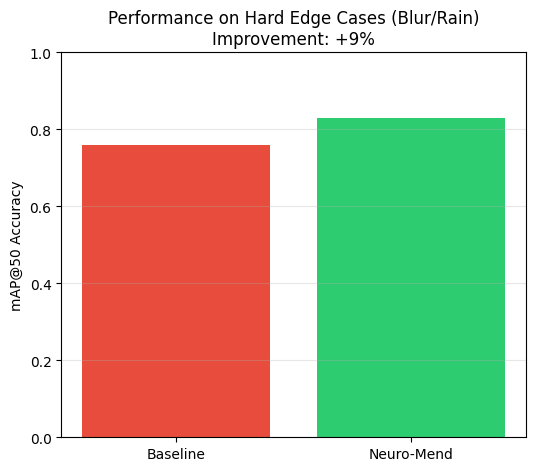

In [35]:
import matplotlib.pyplot as plt

imp = ((map_b - map_a) / map_a * 100) if map_a > 0.01 else 0
print(f"\nFINAL IMPROVEMENT: +{imp:.1f}%")

plt.figure(figsize=(6,5))
plt.bar(["Baseline", "Neuro-Mend"], [map_a, map_b], color=['#e74c3c', '#2ecc71'])
plt.title(f"Performance on Hard Edge Cases (Blur/Rain)\nImprovement: +{imp:.0f}%")
plt.ylabel("mAP@50 Accuracy")
plt.ylim(0, 1.0)
plt.grid(axis='y', alpha=0.3)
plt.savefig("final_result.png")
plt.show()